# Lab | Model generation and validation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
#get files
path_name = 'files_for_lab/csv_files/'
file_name = 'marketing_customer_analysis.csv'
df = pd.read_csv(path_name+file_name)

In [3]:
df.head(3)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


In [4]:
#clean the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer                       9134 non-null   object 
 1   state                          9134 non-null   object 
 2   customer_lifetime_value        9134 non-null   float64
 3   response                       9134 non-null   object 
 4   coverage                       9134 non-null   object 
 5   education                      9134 non-null   object 
 6   effective_to_date              9134 non-null   object 
 7   employmentstatus               9134 non-null   object 
 8   gender                         9134 non-null   object 
 9   income                         9134 non-null   int64  
 10  location_code                  9134 non-null   object 
 11  marital_status                 9134 non-null   object 
 12  monthly_premium_auto           9134 non-null   i

### No multicollinearity
In the previous lab, we found out that there is no multicollinearity between numeric features. The only feature that corrolates with the `total_claim_amount` is `monthly_premium_auto`. The correlation amount is 0.63.

We will remove all numeric columns except for these two: `total_claim_amount` and `monthly_premium_auto`.

In [6]:
#removing all numeric columns except `total_claim_amount` and `monthly_premium_auto`

df_cat = df.select_dtypes(include='object')

df_num = df.select_dtypes(include=np.number)
df_num = df_num[['monthly_premium_auto','total_claim_amount']]

df_features = pd.concat([df_cat, df_num], axis = 1)
df_features.head()



,customer,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,monthly_premium_auto,total_claim_amount
0,BU79786,Washington,No,Basic,Bachelor,2/24/11,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,69,384.811147
1,QZ44356,Arizona,No,Extended,Bachelor,1/31/11,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,94,1131.464935
2,AI49188,Nevada,No,Premium,Bachelor,2/19/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,108,566.472247
3,WW63253,California,No,Basic,Bachelor,1/20/11,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,106,529.881344
4,HB64268,Washington,No,Basic,Bachelor,2/3/11,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,73,138.130879


### Check and remove outliers

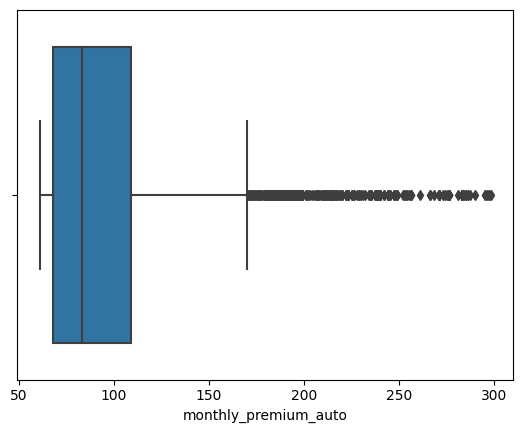

In [7]:
sns.boxplot(data=df_features, x="monthly_premium_auto")
plt.show()

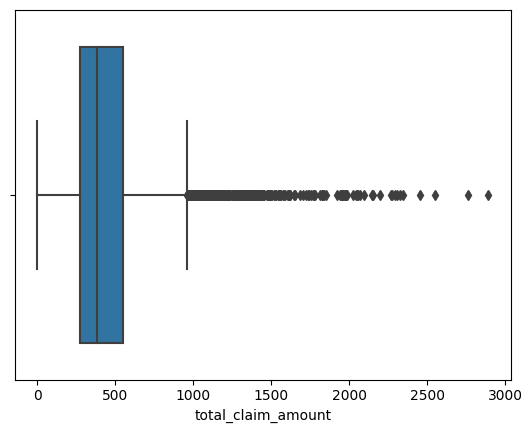

In [8]:
sns.boxplot(data=df_features, x="total_claim_amount")
plt.show()

In [9]:
def remove_outliers(df: pd.DataFrame)-> pd.DataFrame:
    """
    Removes outliers from all numeric columns in a DataFrame
    
    note: we are removing all outliers (from X and y), this means that the model that uses this data set will not 
    be able to predict extreme values for y

    Input
    df: a DataFrame

    Output
    pd.DataFrame
    """
    df_temp = df.copy()

    #get numeric column names as a list
    df_temp_num_cols = list(df_temp.select_dtypes(include=np.number).columns)
    
    for col in df_temp_num_cols:
        #find upper and lower whisker
        iqr = np.percentile(df[col],75) - np.percentile(df[col],25)
        upper_whisker = np.percentile(df_temp[col],75) + 1.5*iqr
        lower_whisker = np.percentile(df_temp[col],25) - 1.5*iqr
    
        #remove outliers from dataframe
        df_temp = df_temp[(df_temp[col]>lower_whisker) & (df_temp[col]<upper_whisker)]

    return df_temp


In [10]:
df_features_no_outliers = remove_outliers(df_features)

In [11]:
#reset index
df_features_no_outliers = df_features_no_outliers.reset_index(drop=True)

### X/y split

In [12]:
y = df_features_no_outliers['total_claim_amount']
X = df_features_no_outliers.drop(['total_claim_amount'], axis=1)

In [13]:
X

,customer,state,response,coverage,education,effective_to_date,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,monthly_premium_auto
0,BU79786,Washington,No,Basic,Bachelor,2/24/11,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,69
1,AI49188,Nevada,No,Premium,Bachelor,2/19/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,108
2,WW63253,California,No,Basic,Bachelor,1/20/11,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,106
3,HB64268,Washington,No,Basic,Bachelor,2/3/11,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,73
4,OC83172,Oregon,Yes,Basic,Bachelor,1/25/11,Employed,F,Rural,Married,Personal Auto,Personal L3,Offer2,Web,Two-Door Car,Medsize,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8457,LA72316,California,No,Basic,Bachelor,2/10/11,Employed,M,Urban,Married,Personal Auto,Personal L1,Offer2,Web,Four-Door Car,Medsize,73
8458,PK87824,California,Yes,Extended,College,2/12/11,Employed,F,Suburban,Divorced,Corporate Auto,Corporate L3,Offer1,Branch,Four-Door Car,Medsize,79
8459,TD14365,California,No,Extended,Bachelor,2/6/11,Unemployed,M,Suburban,Single,Corporate Auto,Corporate L2,Offer1,Branch,Four-Door Car,Medsize,85
8460,UP19263,California,No,Extended,College,2/3/11,Employed,M,Suburban,Married,Personal Auto,Personal L2,Offer3,Branch,Four-Door Car,Large,96


In [14]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 8462 entries, 0 to 8461
Series name: total_claim_amount
Non-Null Count  Dtype  
--------------  -----  
8462 non-null   float64
dtypes: float64(1)
memory usage: 66.2 KB


### Train/Test split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=22)

### Use the pd.DataFrame() function to create new Pandas DataFrames from the X_train, and X_test Numpy arrays obtained in the previous step (make sure to use the columns= option to set the columns names to X.columns).

In [16]:
X_train_df = pd.DataFrame(X_train, columns = X.columns)
X_test_df  = pd.DataFrame(X_test,  columns = X.columns)

### Split the X_train and X_test Pandas DataFrame into two: numerical, and categorical using df.select_dtypes()

In [17]:
X_train_df_cat = X_train_df.select_dtypes(include = 'object')
X_train_df_num = X_train_df.select_dtypes(include=np.number)

X_test_df_cat = X_test_df.select_dtypes(include = 'object')
X_test_df_num = X_test_df.select_dtypes(include=np.number)

### Checking to see if the numerical column in X_train needs to be transformed (scaled, transformed)

In [18]:
X_train_df_num.skew() #no skew so no need to transform

monthly_premium_auto    0.783782
dtype: float64

In [19]:
X_train_df_num.describe() #no need to scale because we only have one numeric column

,monthly_premium_auto
count,5923.000000
mean,86.609657
std,22.184657
min,61.000000
25%,68.000000
50%,79.000000
75%,105.000000
max,170.000000


There is only one column in the X dataset, `monthly_premium_auto`. This column isn't skewed, and since there is only one column, there's only one range of values so they won't need to be scaled.

### Transform the categorical columns into numbers using OneHotEncoder 

In [20]:
#getting nominal columns from cat dataframes
X_train_df_cat = X_train_df_cat.drop(['customer', 'effective_to_date'], axis = 1)
X_test_df_cat = X_test_df_cat.drop(['customer', 'effective_to_date'], axis = 1)

display(X_train_df_cat.head(3))
display(X_test_df_cat.head(3))

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
7958,California,Yes,Basic,College,Unemployed,F,Suburban,Married,Personal Auto,Personal L2,Offer1,Agent,SUV,Medsize
5301,California,No,Extended,High School or Below,Employed,M,Suburban,Single,Personal Auto,Personal L3,Offer4,Branch,Four-Door Car,Small
8289,California,No,Basic,College,Employed,F,Rural,Married,Personal Auto,Personal L2,Offer2,Branch,Four-Door Car,Medsize


,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size
7985,California,No,Extended,College,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer3,Web,SUV,Medsize
841,Nevada,No,Premium,Master,Employed,F,Rural,Married,Corporate Auto,Corporate L3,Offer3,Branch,Two-Door Car,Large
1845,California,Yes,Basic,High School or Below,Employed,F,Suburban,Single,Personal Auto,Personal L3,Offer2,Call Center,Four-Door Car,Medsize


In [21]:
from sklearn.preprocessing import OneHotEncoder

### Fit with OneHotEncoder and then save as pkl

In [22]:
encoder = OneHotEncoder() # drop='first' Color(R,G,B), categories=[list_of_possible_values_for_col1 ,... ,... ]
encoder.fit(X_train_df_cat)

#save the encoder as pkl
path = "encoders/"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist
  os.makedirs(path)
  print("The new directory is created!")

filename = "cat_encoder.pkl" # use a descriptive name for your encoder but keep the ".pkl" file extension
with open(path+filename, "wb") as file:
   pickle.dump(encoder, file) # Replace "variable" with the name of the variable that contains your transformer


### Transform the cat values in X_train and X_test

In [23]:
#apply transform to X_train
X_train_df_cat_transformed = encoder.transform(X_train_df_cat).toarray()
X_train_df_cat_transformed_df = pd.DataFrame(X_train_df_cat_transformed, columns=encoder.get_feature_names_out())

#aply transform to X_test
X_test_df_cat_transformed = encoder.transform(X_test_df_cat).toarray()
X_test_df_cat_transformed_df = pd.DataFrame(X_test_df_cat_transformed, columns=encoder.get_feature_names_out())

### Concat the num and cat datasets for X_train and X_test

In [24]:
X_train_df_num.reset_index(drop=True, inplace=True)

In [25]:
X_train_df_num.shape

(5923, 1)

In [26]:
X_train_df_cat_transformed_df.reset_index(drop=True, inplace=True)

In [27]:
X_train_df_cat_transformed_df.shape

(5923, 55)

In [28]:
X_train_df_num.head()

,monthly_premium_auto
0,107
1,95
2,65
3,65
4,64


In [29]:
X_train_df_cat_transformed_df.head()

,state_Arizona,state_California,state_Nevada,state_Oregon,state_Washington,response_No,response_Yes,coverage_Basic,coverage_Extended,coverage_Premium,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Four-Door Car,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Large,vehicle_size_Medsize,vehicle_size_Small
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [30]:
#train datasets
X_train_df_all = pd.concat([X_train_df_num, X_train_df_cat_transformed_df], axis=1)

In [31]:
X_train_df_all.head()

,monthly_premium_auto,state_Arizona,state_California,state_Nevada,state_Oregon,state_Washington,response_No,response_Yes,coverage_Basic,coverage_Extended,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Four-Door Car,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Large,vehicle_size_Medsize,vehicle_size_Small
0,107,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,95,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,65,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,65,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,64,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
X_train_df_all.shape

(5923, 56)

In [33]:
#reset indexes of test datasets
X_test_df_num.reset_index(drop=True, inplace=True)
X_test_df_num.shape

(2539, 1)

In [34]:
X_test_df_cat_transformed_df.reset_index(drop=True, inplace=True)
X_test_df_cat_transformed_df.shape

(2539, 55)

In [35]:
#test datasets
X_test_df_all = pd.concat([X_test_df_num, X_test_df_cat_transformed_df], axis = 1)

In [36]:
X_test_df_all.shape

(2539, 56)

In [37]:
X_test_df_all.head()

,monthly_premium_auto,state_Arizona,state_California,state_Nevada,state_Oregon,state_Washington,response_No,response_Yes,coverage_Basic,coverage_Extended,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Four-Door Car,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Large,vehicle_size_Medsize,vehicle_size_Small
0,121,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,113,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,71,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,72,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,70,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Fit MinMaxScaler to X_train and save as pkl

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_df_all)

path = "scalers/"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist
  os.makedirs(path)
  print("The new directory is created!")

filename = "min_max_scaler_all_features.pkl" # use a descriptive name for your encoder but keep the ".pkl" file extension
with open(path+filename, "wb") as file:
   pickle.dump(scaler, file) # Replace "variable" with the name of the variable that contains your transformer



### Scale X_train and X_test

In [39]:
X_train_df_all.head()

,monthly_premium_auto,state_Arizona,state_California,state_Nevada,state_Oregon,state_Washington,response_No,response_Yes,coverage_Basic,coverage_Extended,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Four-Door Car,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Large,vehicle_size_Medsize,vehicle_size_Small
0,107,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,95,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,65,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,65,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,64,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
X_train_transformed_scaled = scaler.transform(X_train_df_all)
X_train_transformed_scaled_df = pd.DataFrame(X_train_transformed_scaled, columns = X_train_df_all.columns, index = y_train.index)

In [41]:
X_test_transformed_scaled = scaler.transform(X_test_df_all)
X_test_transformed_scaled_df = pd.DataFrame(X_test_transformed_scaled, columns = X_train_df_all.columns, index= y_test.index)

### Training linear model

In [42]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train_transformed_scaled_df, y_train)

path = "models/"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory because it does not exist
  os.makedirs(path)
  print("The new directory is created!")

  filename = "lin_model.pkl" # use a descriptive name for your encoder but keep the ".pkl" file extension
  with open(path+filename, "wb") as file:
    pickle.dump(linear_model, file) # Replace "variable" with the name of the variable that contains your transformer

In [43]:
X_train_transformed_scaled_df.head()

,monthly_premium_auto,state_Arizona,state_California,state_Nevada,state_Oregon,state_Washington,response_No,response_Yes,coverage_Basic,coverage_Extended,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Four-Door Car,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Large,vehicle_size_Medsize,vehicle_size_Small
7958,0.422018,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5301,0.311927,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8289,0.036697,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
512,0.036697,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
8381,0.027523,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Getting model predictions

In [44]:
y_train_pred = linear_model.predict(X_train_transformed_scaled_df)
y_test_pred = linear_model.predict(X_test_transformed_scaled_df)

### Model evaluation

In [54]:
results = {"Set": ["Train"]*X_train_transformed_scaled_df.shape[0] + ["Test"]*X_test_transformed_scaled_df.shape[0], 
           "Real": y_train.tolist() + y_test.tolist(),
           "Predicted": y_train_pred.tolist() + y_test_pred.tolist()}

results_df = pd.DataFrame(results)
results_df.head()

,Set,Real,Predicted
0,Train,513.60000,562.00
1,Train,456.00000,561.75
2,Train,10.36741,5.50
3,Train,312.00000,385.50
4,Train,307.20000,416.00


In [58]:
#adding error of the model to the above table
results_df['Errors'] = results_df['Real'] - results_df['Predicted']
results_df.head()

,Set,Real,Predicted,Errors
0,Train,513.60000,562.00,-48.40000
1,Train,456.00000,561.75,-105.75000
2,Train,10.36741,5.50,4.86741
3,Train,312.00000,385.50,-73.50000
4,Train,307.20000,416.00,-108.80000


### Error metrics

In [55]:
def error_metrics_report(y_real_train: list, y_real_test: list, y_pred_train: list, y_pred_test: list) -> pd.DataFrame:
    '''
    Function calculates error values (MAE, MSE, RMSE, R2) for the train and test data sets

    Input
    y_real_train: list of real value from the train set
    y_real_test: list of real values from the test set
    y_pred_train: list of predicted values from the train set
    y_pred_test: list of predicted values from the test set

    Output
    pd.DataFrame: error values DataFrame

    '''
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    MAE_train = mean_absolute_error(y_real_train, y_pred_train)
    MAE_test  = mean_absolute_error(y_real_test,  y_pred_test)

    # Mean squared error
    MSE_train = mean_squared_error(y_real_train, y_pred_train)
    MSE_test  = mean_squared_error(y_real_test,  y_pred_test)

    # Root mean squared error
    RMSE_train = mean_squared_error(y_real_train, y_pred_train, squared=False)
    RMSE_test  = mean_squared_error(y_real_test,  y_pred_test, squared=False)

    # R2
    R2_train = r2_score(y_real_train, y_pred_train)
    R2_test  = r2_score(y_real_test,  y_pred_test)

    results = {"Metric": ['MAE','MSE','RMSE','R2'], 
               "Train": [MAE_train, MSE_train, RMSE_train, R2_train],
               "Test": [MAE_test, MSE_test, RMSE_test, R2_test]}

    results_df = pd.DataFrame(results).round(2)

    return results_df

In [56]:
error_metrics_report(list(results_df[results_df["Set"]=="Train"]["Real"]),
                     list(results_df[results_df["Set"]=="Test"]["Real"]),
                     list(results_df[results_df["Set"]=="Train"]["Predicted"]),
                     list(results_df[results_df["Set"]=="Test"]["Predicted"]))

,Metric,Train,Test
0,MAE,72.42,71.47
1,MSE,8815.59,8457.31
2,RMSE,93.89,91.96
3,R2,0.79,0.79


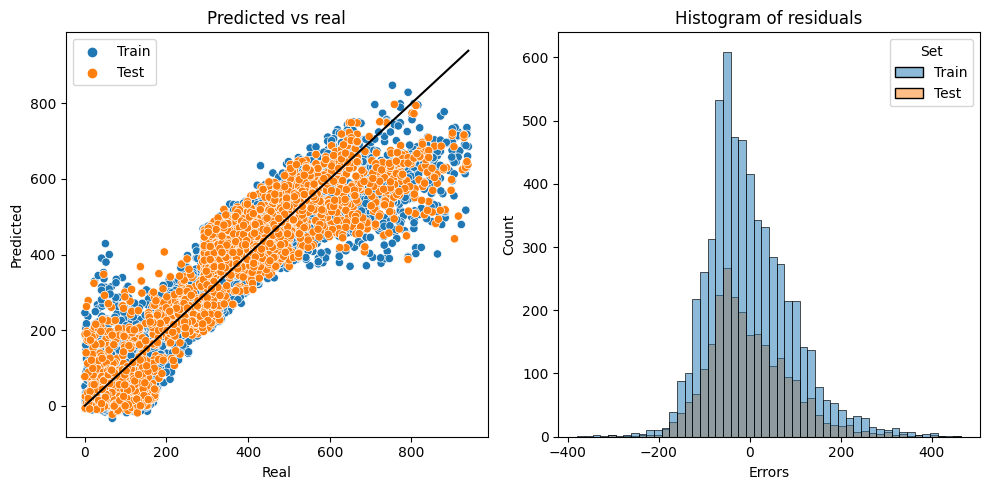

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(10,5))

sns.scatterplot(results_df, x="Real", y="Predicted", hue="Set", ax=ax[0])
sns.lineplot(results_df, x="Real", y="Real", color="black", ax=ax[0])
ax[0].set_title("Predicted vs real")
sns.histplot(results_df, x="Errors", bins=50, hue="Set", ax=ax[1])
ax[1].set_title("Histogram of residuals")

plt.tight_layout()
plt.show()